In [6]:
import io, requests, glob, os
import requests
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL

In [7]:
def plot_param(params, title, data):
    params = params if type(params) in (tuple, list) else [params]
    maxDate = data["Datum"].max()
    fig, axs = plt.subplots(5, 2, figsize=(20, 20), constrained_layout=True)
    fig.suptitle(
        f'{title} bis {maxDate.strftime("%#d. %b %Y")}',
        fontweight="bold", fontsize="xx-large")
    i = 0

    for bl in data["Name"].unique():
        data_bl = data.loc[data["Name"] == bl]
        axis = axs[int(i / 2), i % 2]
        axis.xaxis.set_major_locator(mdates.MonthLocator())
        axis.xaxis.set_minor_locator(
            mdates.WeekdayLocator(byweekday=mdates.MO))
        axis.set_title(bl,
                       fontweight="bold" if bl == "Österreich" else "normal")
        j = 0
        secondAxis = axis.twinx() if len(params) > 1 else None
        for param in params:
            currentAxis = axis if j == 0 else secondAxis
            res = STL(data_bl.loc[:, param], period=7).fit()
            if j == 0:
                currentAxis.plot(res.observed)
                currentAxis.plot(res.trend)
            else:
                currentAxis.plot(res.trend, color="gray", linewidth=1)
            j = j + 1
        axis.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
        axis.grid(True, which="minor", axis="x")
        axis.grid(True, which="major", axis="y")
        i = i + 1
        if bl == "Österreich":
            for a in ['top', 'bottom', 'left', 'right']:
                axis.spines[a].set_linewidth(2)
            #plt.rc("figure", figsize=(16, 8))
            #res.plot()
    plt.show()
    fig.savefig(f'{title}_{dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d%H%M%S")}.png', facecolor="white", dpi=96)


In [8]:

requests.packages.urllib3.disable_warnings()
requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS += 'HIGH:!DH:!aNULL'

req = requests.get(
    "https://info.gesundheitsministerium.gv.at/data/timeline-faelle-bundeslaender.csv", verify=False)
with open("timeline-faelle-bundeslaender.csv", "wb") as f:
    f.write(req.content)

data = pd.read_table(
    io.StringIO(req.content.decode("utf-8-sig")),
    sep=";", header=0, parse_dates=[0])

data["TestungenPCRTaeglich"] = data["TestungenPCR"].diff(periods=10)
data["HospitalisierungTaeglich"] = data["Hospitalisierung"].diff(periods=10)
data["Neuinfektionen"] = data["BestaetigteFaelleBundeslaender"].diff(periods=10)
for bl in data["Name"].unique():
    for param in ["TestungenPCRTaeglich", "HospitalisierungTaeglich", "Hospitalisierung", "Neuinfektionen"]:
        mean = data.loc[data["Name"] == bl, param].mean()
        stdev = data.loc[data["Name"] == bl, param].std()
        minVal = 0 if (param == "TestungenPCRTaeglich" or param == "Neuinfektionen") else mean - 5 * stdev
        maxVal = mean + 5 * stdev
        data.loc[(data["Name"] == bl) & ((data[param] < minVal) | (data[param] > maxVal)), param] = np.nan
        data.loc[data["Name"] == bl, param] = data.loc[data["Name"] == bl, param].fillna(method="bfill")
        data.loc[data["Name"] == bl, param] = data.loc[data["Name"] == bl, param].fillna(method="ffill")
data.to_csv("timeline-faelle-bundeslaender.csv", encoding='utf-8', index=False)


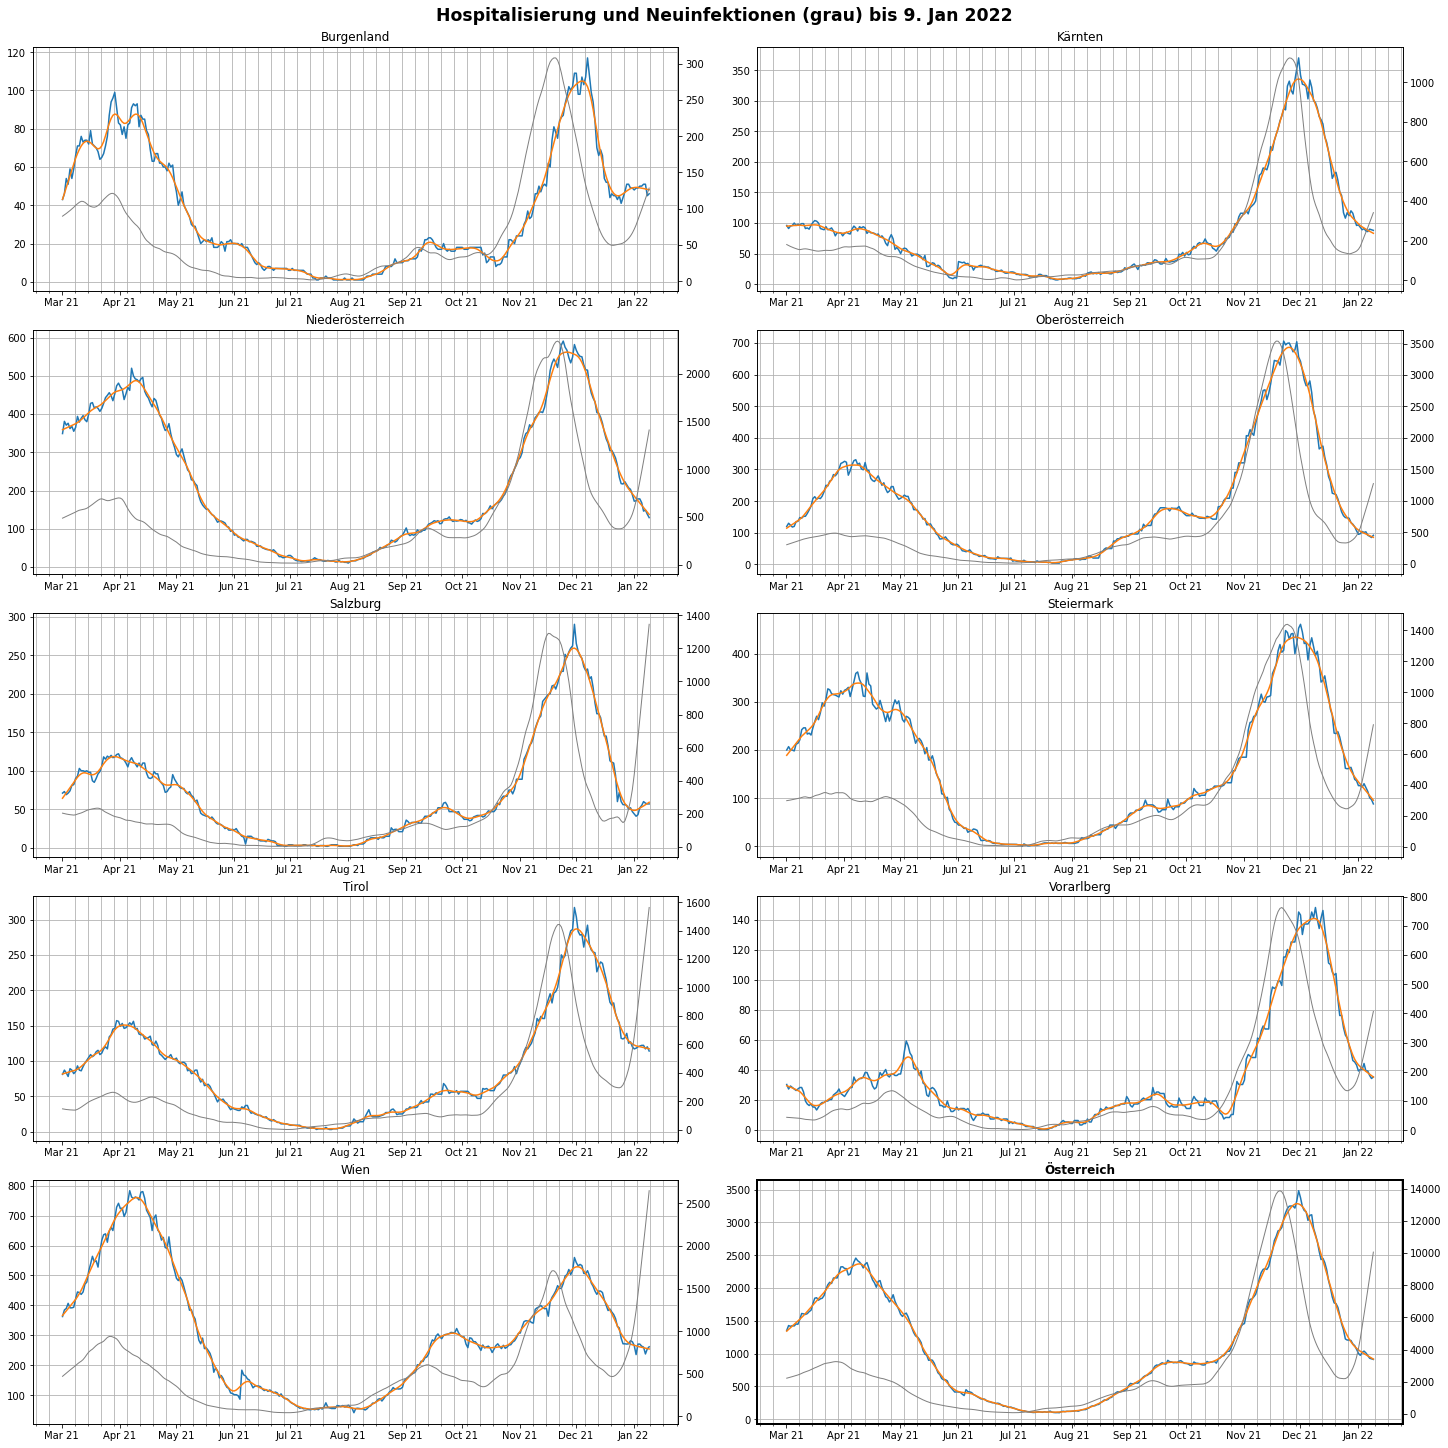

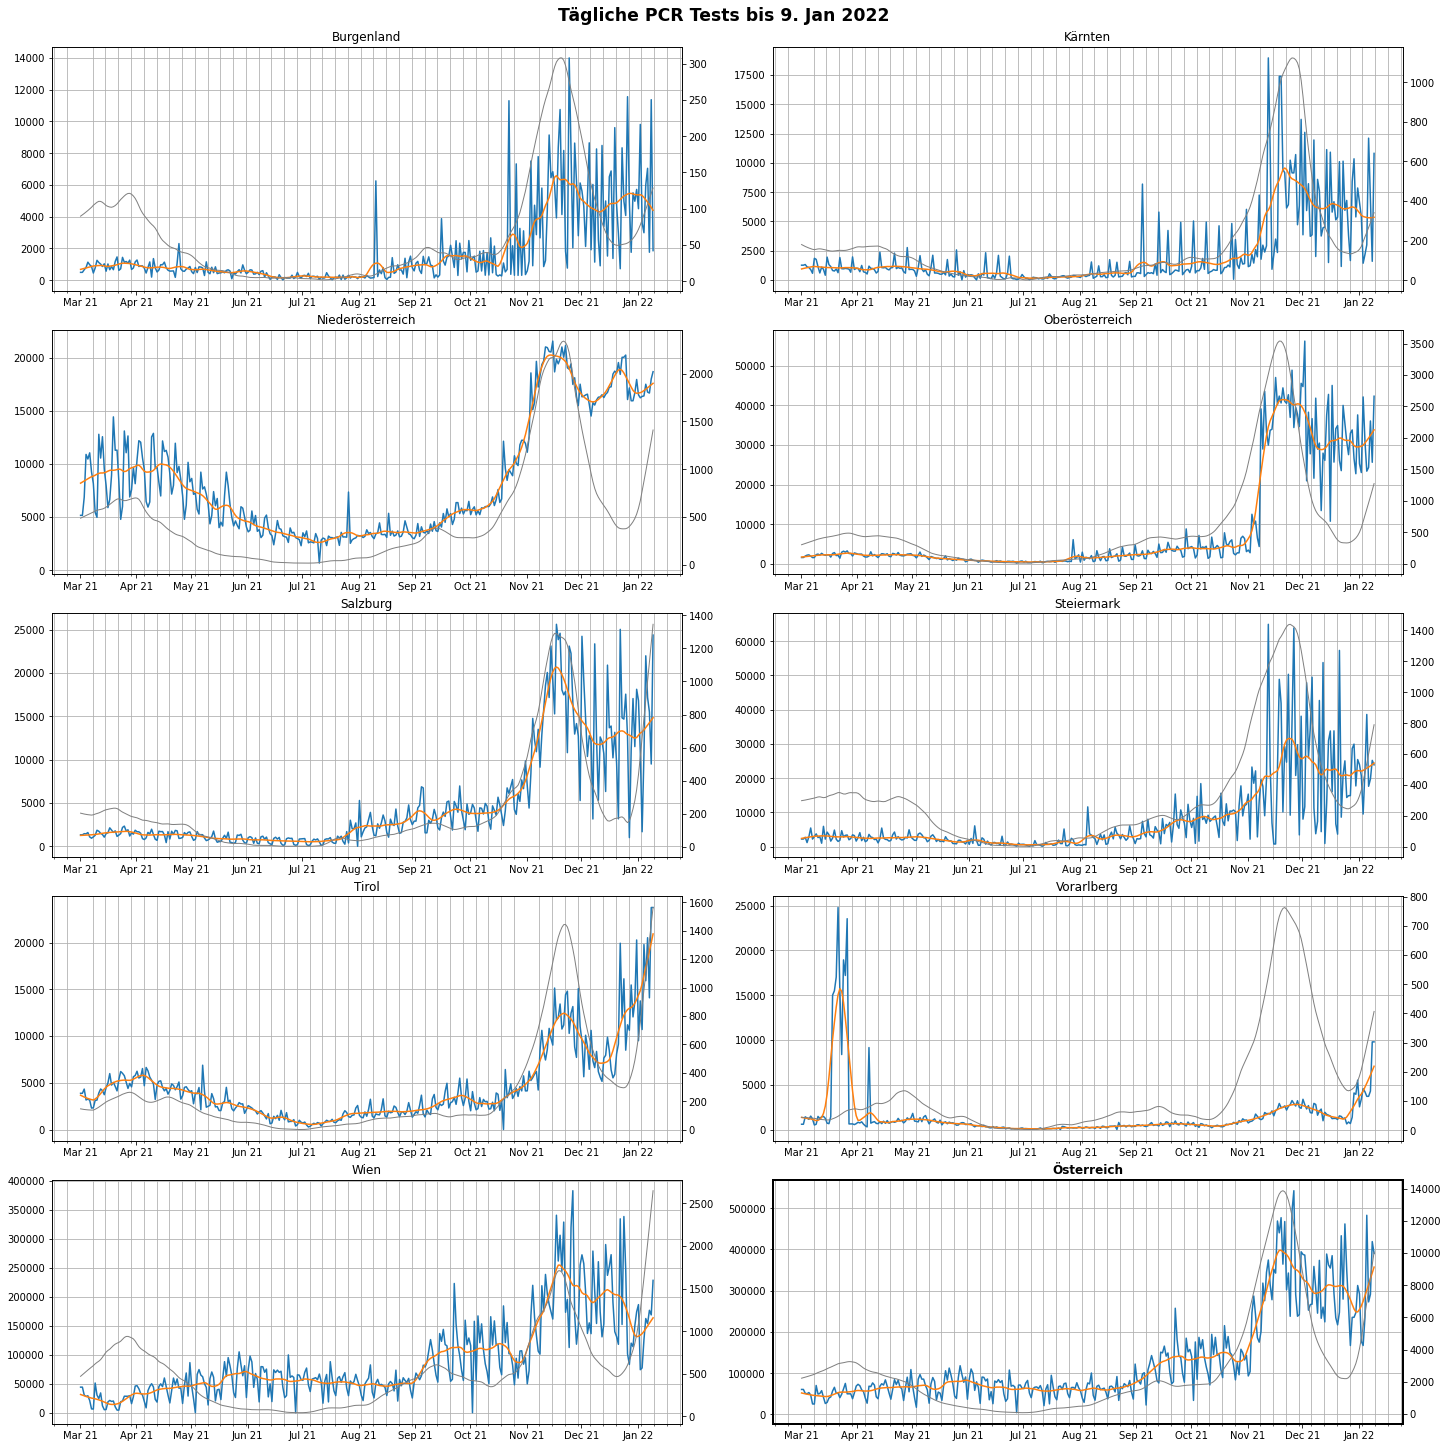

In [9]:
data = pd.read_csv("timeline-faelle-bundeslaender.csv",
                   encoding='utf-8', parse_dates=[0])
data.set_index("Datum", drop=False, inplace=True)
for file in glob.glob('*.png'):
    os.remove(file)
plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (grau)", data)
plot_param(["TestungenPCRTaeglich", "Neuinfektionen"], "Tägliche PCR Tests und Neuinfektionen (grau)", data)
